In [10]:
import numpy as np
# from collections import * 
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict

In [11]:
class Env_real:
    
    def __init__(self,num_of_arms,reward_prob):
        self.num_of_arms=num_of_arms
        self.reward_prob=reward_prob

    def step(self,action):
        try:
            rwd=np.random.binomial(1,self.reward_prob[action])
        except IndexError:
            print("The arm doent exist")

        return rwd

class Env_model:
    def __init__(self,num_of_arms):
        self.num_of_arms=num_of_arms
        self.beta_param=np.ones(shape=(self.num_of_arms,2))
    
    def reset(self):
        self.beta_param=np.ones(shape=(self.num_of_arms,2))
        
    def update_env_param_step(self,action,reward):
        if reward:
            self.beta_param[action][0]+=1
        else:
            self.beta_param[action][1]+=1
        return
    def get_reward(self,action):
        alpha,beta=self.beta_param[action][0],self.beta_param[action][1]
        p=np.random.beta(alpha,beta)
        reward=np.random.binomial(1,p)        
        return reward

class Env_model_simple:
    def __init__(self,num_of_arms):
        self.num_of_arms=num_of_arms
        self.param=np.zeros(shape=(self.num_of_arms,1))
        self.counter=defaultdict(int)
    
    def reset(self):
        self.param=np.ones(shape=(self.num_of_arms,1))
        self.counter=defaultdict(int)
        
    def update_env_param_step(self,action,reward):
        self.param[action]=(self.param[action]*self.counter[action]/(self.counter[action]+1))+(reward/(self.counter[action]+1))
        return
    def get_reward(self,action):
        # alpha,beta=self.beta_param[action][0],self.beta_param[action][1]
        p=self.param[action]
        reward=np.random.binomial(1,p)        
        return reward

class Buffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def flush_all(self):
        self.buffer = []
        self.position = 0
        return

    def push(self,action, reward):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (action, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        batch = np.random.sample(self.buffer, int(batch_size))
        action, reward= map(np.stack, zip(*batch))
        return action, reward

class PG_Learner:
    def __init__(self,env,alpha=1,temp=1,with_prior=True):
        
        self.env=env
        if with_prior:
            self.env_model=Env_model(self.env.num_of_arms)
        else:
            self.env_model=Env_model_simple(self.env.num_of_arms)
        self.D_fake=Buffer(capacity=10000)
        
        self.params=np.ones(self.env.num_of_arms)
        
        self.alpha=alpha
        self.temp=1
        
        self.action_hist=[]
        self.reward_hist=[]
        self.P_hist=[]
        
        
        self.last_visited_Dreal=0
        self.last_visited_Dfake=0
        
   
    def Reset(self):
        
        self.params=np.ones(self.env.num_of_arms)
        self.env_model.reset()        
        self.action_hist=[]
        self.reward_hist=[]
        self.P_hist=[]
        
        return

    def get_P(self):
        
        exp = np.exp(self.params / self.temp)
        total = np.sum(exp)
        P = exp / total
        
        return P
    
    def action(self):
        # update current_action
        
        probabilities = self.get_P()
        # print(probabilities)
        action = np.random.choice(self.env.num_of_arms, 1, p=probabilities)[0]
        self.P_hist.append(probabilities)
        
        return action

    def update_param_from_step(self,action,reward):
        
        # update the param based on action and reward for a "STEP"
        

        
        # compute reward baseline by taking mean of all rewards till t-1
        
        if len(self.reward_hist) <= 1:
            reward_baseline = 0.0
        else:
            reward_baseline = np.mean(self.reward_hist[:-1])

        current_probailities = self.get_P()
        reward_baseline=0
        # update Q values for the action taken and those not taken seperately
        
        self.params[action] += (
            self.alpha * (reward - reward_baseline) * (1 - current_probailities[action])
        )
        
        ## Modified Below
        
        # self.params[action] += (
        #     self.alpha * (reward - reward_baseline) * (current_probailities[action])
        # )
        
        
        actions_not_taken = np.arange(self.env.num_of_arms) != action
        self.params[actions_not_taken] += (
            -1
            * self.alpha
            * (reward - reward_baseline)
            * current_probailities[actions_not_taken]
        )
        
        # Modified Below
        
        # actions_not_taken = np.arange(self.env.num_of_arms) != action
        # # print(actions_not_taken)
        # self.params[actions_not_taken]+=float(
        #     -1
        #     * self.alpha
        #     * (reward - reward_baseline)
        #     *self.params[actions_not_taken]*current_probailities[action]
        # )
        
        
        return 
    
    def update_param_from_buffer(self,Buffer,mult_factor=1):
        
        # Assumptions:
        
       # 1. The code will work only for the case where numb_of_interactions=1
       
        

        for i in range(self.last_visited_Dreal,Buffer.position):
            self.env_model.update_env_param_step(Buffer.buffer[i][0],Buffer.buffer[i][1])
            
        self.last_visited_Dreal=Buffer.position
        
        while self.D_fake.position!=mult_factor*Buffer.position:
            action,reward=self.Get_fakedata_step()
            self.D_fake.push(action,reward)
            
        
        # 1. Real Only 


        if self.Latest_only:
            self.reward_hist=[x[1] for x in Buffer.buffer[:-1]]
            self.action_hist=[x[0] for x in Buffer.buffer[:-1]]
            self.update_param_from_step(Buffer.buffer[-1][0],Buffer.buffer[-1][1])
            
            for i in range(1,mult_factor+1):
                self.reward_hist=[x[1] for x in self.D_fake.buffer[:-i]]
                self.action_hist=[x[0] for x in self.D_fake.buffer[:-i]]
                
                self.update_param_from_step(self.D_fake.buffer[-i][0],self.D_fake.buffer[-i][1])
                
                
                
            
            
        else:
            for tup_id in range(Buffer.position+1):
                # update 
                self.reward_hist=[x[1] for x in Buffer.buffer[:tup_id]]
                self.action_hist=[x[0] for x in Buffer.buffer[:tup_id]]
                
                self.update_param_from_step(Buffer.buffer[tup_id][0],Buffer.buffer[tup_id][1])
            
        return

    def Get_fakedata_step(self):
        action=self.action()
        alpha,beta=self.env_model.beta_param[action][0],self.env_model.beta_param[action][1]
        p=np.random.beta(alpha,beta)
        reward=np.random.binomial(1,p)        
        return action,reward

def Check_the_quality(Agent,env):
    k=100
    N=20
    
    list_of_sum=[]
    for j in range(N):
        sum_of_rwrd=0
        for i in range(k):
            action=Agent.action()
            reward=env.step(action)
            sum_of_rwrd+=reward
        list_of_sum.append(sum_of_rwrd/k)
    return np.asarray(list_of_sum).mean()


## Instantiation

In [35]:
P_star=[0.6,0.5]
env=Env_real(num_of_arms=2,reward_prob=P_star)
Agent=PG_Learner(env=env,alpha=0.01,with_prior=True)

## init

In [36]:
Agent.params=np.ones(env.num_of_arms)
Agent.env_model.beta_param=np.ones(shape=(env.num_of_arms,2))
# Agent.env_model.param=np.ones(shape=(env.num_of_arms,1))
# gamma=0.9999
# gamma=0
gamma=0.1

mode_list=[]
param_list=[]
Quality_list=[]


## Vanilla Alg

In [23]:
Agent.params=np.array([1.0,1.0])
print("Before learning : ",)
print(Agent.params)


for t in tqdm(range(2500)):
    i=Agent.action()
    mode=np.random.binomial(n=1,p=(1-gamma))
    mode_list.append(mode) # For debugging
    param_list.append(tuple(Agent.params)) #  For debugging
    Quality_list.append(Check_the_quality(Agent,env)) # For debugging
    if mode==0:
        r_i=np.random.binomial(n=1,p=P_star[i])
        Agent.env_model.update_env_param_step(i,r_i)
    if mode==1:
        r_i=Agent.env_model.get_reward(i)
    Agent.reward_hist.append(r_i)
    Agent.update_param_from_step(i,r_i)
    

print("After learning : ",)
print(Agent.params)
print("mode_count = (real,fake) :",(mode_list.count(0),mode_list.count(1)))
trans_point=[i for i, x in enumerate(mode_list) if x == 0]

Before learning : 
[1. 1.]


100%|██████████| 2500/2500 [01:53<00:00, 21.96it/s]

After learning : 
[1.87316474 0.12683526]
mode_count = (real,fake) : (260, 2240)


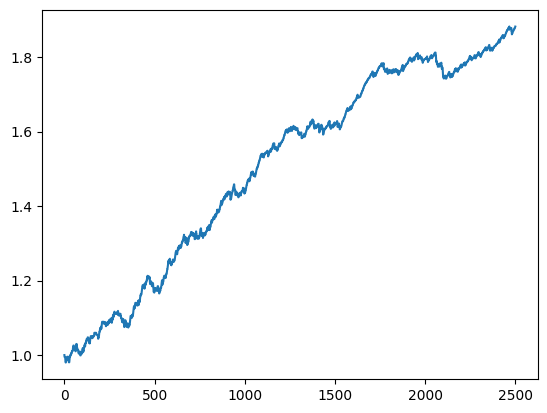

In [24]:
theta_0_list=[x[0] for x in param_list]
plt.plot(theta_0_list)

# Variation with gamma parameter

In [60]:
Gamma_Q_dict=dict()
Gamma_M_dict=dict()

# for i in range(100):

for gamma in [0.7,0.8,0.9,0.999,1]:
    Gamma_Q_dict=dict()
    Gamma_M_dict=dict()
    
    print("For Gamma = ", gamma)
    
    # Agent.params=np.ones(env.num_of_arms)
    Agent.Reset()
    Agent.params=np.array([1.0,1.0])
    
    Agent.env_model.param=np.ones(shape=(env.num_of_arms,2))
    
    mode_list=[]
    param_list=[]
    Quality_list=[]
    
    print("Before learning : ",)
    print(Agent.params)

    T=20000
    for t in tqdm(range(T)):
        i=Agent.action()
        mode=np.random.binomial(n=1,p=gamma)
        mode_list.append(mode) # For debugging
        param_list.append(Agent.params[0]) #  For debugging
        if t%50==0:
            Quality_list.append(None) # For debugging
        if mode==0:
            r_i=np.random.binomial(n=1,p=P_star[i])
            Agent.env_model.update_env_param_step(i,r_i)
        if mode==1:
            r_i=Agent.env_model.get_reward(i)
        Agent.reward_hist.append(r_i)
        Agent.update_param_from_step(i,r_i)
        if t==T-1:
            Gamma_Q_dict.update({gamma:param_list})
            Gamma_M_dict.update({gamma:mode_list.count(0)})
    print("After learning : ",)
    print(Agent.params)
    print("\n\n\n")

# print("Gamma Dictionary : ",Gamma_dict)





For Gamma =  0.7
Before learning : 
[1. 1.]


100%|██████████| 20000/20000 [00:11<00:00, 1671.28it/s]


After learning : 
[ 2.56319408 -0.56319408]




For Gamma =  0.8
Before learning : 
[1. 1.]


100%|██████████| 20000/20000 [00:11<00:00, 1736.50it/s]


After learning : 
[ 2.81718799 -0.81718799]




For Gamma =  0.999
Before learning : 
[1. 1.]


100%|██████████| 20000/20000 [00:11<00:00, 1758.26it/s]


After learning : 
[ 3.42439448 -1.42439448]




For Gamma =  1
Before learning : 
[1. 1.]


100%|██████████| 20000/20000 [00:11<00:00, 1693.00it/s]

After learning : 
[1.20306501 0.79693499]






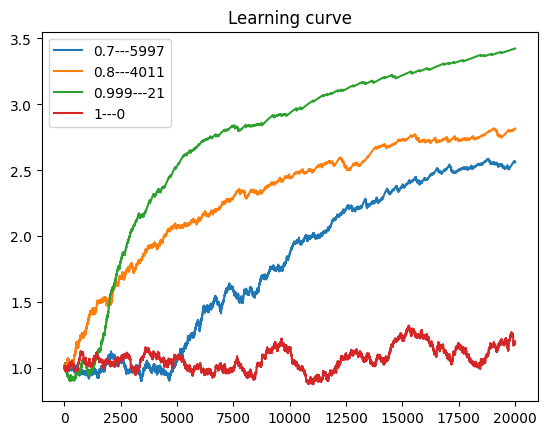

In [62]:
for gamma in Gamma_Q_dict.keys():
    plt.plot(Gamma_Q_dict[gamma],label=str(gamma)+"---"+str(Gamma_M_dict[gamma]))
plt.title("Learning curve")
plt.legend()
plt.show()

## Report: mode count

In [8]:
print("mode_count = ",(mode_list.count(0),mode_list.count(1)))
print("trans_point = ",trans_point)


mode_count =  (0, 5000)
trans_point =  [0, 1, 3, 5, 6, 10, 11, 13, 15, 16, 18, 23, 24, 27, 28, 29, 30, 31, 34, 37, 39, 42, 44, 45, 46, 47, 48, 49, 52, 53, 55, 57, 58, 60, 63, 64, 65, 66, 67, 68, 70, 72, 73, 75, 78, 79, 81, 83, 84, 85, 86, 88, 89, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 107, 110, 111, 112, 113, 116, 119, 120, 121, 123, 124, 126, 127, 128, 130, 131, 134, 135, 136, 137, 139, 140, 142, 143, 147, 149, 152, 154, 156, 157, 158, 159, 160, 164, 168, 169, 170, 171, 174, 176, 177, 179, 182, 184, 185, 187, 188, 189, 191, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 206, 207, 208, 210, 211, 214, 219, 222, 227, 228, 229, 232, 233, 234, 235, 236, 237, 238, 240, 241, 243, 244, 246, 248, 249, 250, 251, 252, 254, 255, 256, 258, 259, 262, 263, 265, 269, 271, 276, 277, 278, 279, 280, 281, 282, 284, 286, 287, 290, 291, 292, 293, 294, 296, 299, 300, 301, 304, 305, 306, 308, 309, 311, 312, 314, 315, 317, 319, 322, 325, 327, 332, 333, 334, 337, 338, 339, 341, 342, 343, 346, 347, 

## Report: parameter variation

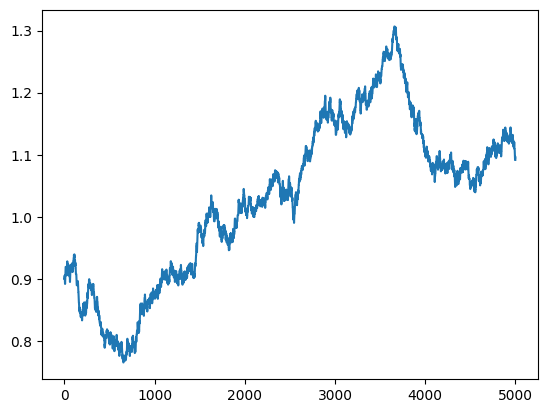

In [136]:
first_param=[x[0] for x in param_list]
sec_param=[x[1] for x in param_list]
from matplotlib import pyplot as pl
plt.plot(first_param)
# plt.plot(sec_param)


## Report: learning curve

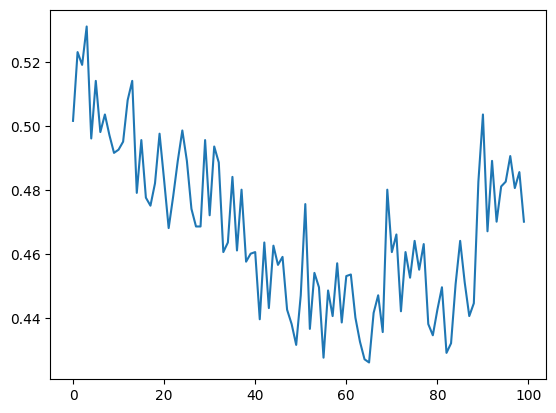

In [10]:
Q_value=Check_the_quality(Agent,env)
plt.plot(Quality_list)


In [11]:
Q_value

0.465

# With Multiplicity included

## instantiation

In [12]:
P_star=[0.2,0.8]
env=Env_real(num_of_arms=2,reward_prob=P_star)
Agent=PG_Learner(env=env,alpha=0.01)

## Init

In [13]:
Agent.params=np.ones(env.num_of_arms)
Agent.env_model.beta_param=np.ones(shape=(env.num_of_arms,2))
# gamma=1.0
gamma=0.99
MULTIPLICITY=1

mode_list=[]
param_list=[]
Quality_list=[]


## Alg with Multiplicity included

In [14]:
print("Before learning : ",)
print(Agent.params)


for t in range(100):
    mode=np.random.binomial(n=1,p=gamma)
    mode_list.append(mode) # For debugging
    param_list.append(tuple(Agent.params)) #  For debugging
    Quality_list.append(Check_the_quality(Agent,env)) # For debugging
    if mode==0:
        i=Agent.action()
        r_i=np.random.binomial(n=1,p=P_star[i])
        Agent.env_model.update_env_param_step(i,r_i)
        Agent.reward_hist.append(r_i)
        Agent.update_param_from_step(i,r_i)
    if mode==1:
        for j in range(MULTIPLICITY):
            i=Agent.action()
            r_i=Agent.env_model.get_reward(i)
            Agent.reward_hist.append(r_i)
            Agent.update_param_from_step(i,r_i)
    
    

print("After learning : ",)
print(Agent.params)
print("mode_count = (real,fake) :",(mode_list.count(0),mode_list.count(1)))
trans_point=[i for i, x in enumerate(mode_list) if x == 0]

Before learning : 
[1. 1.]
After learning : 
[0.97640082 1.02359918]
mode_count = (real,fake) : (1, 99)


## Parameter variation

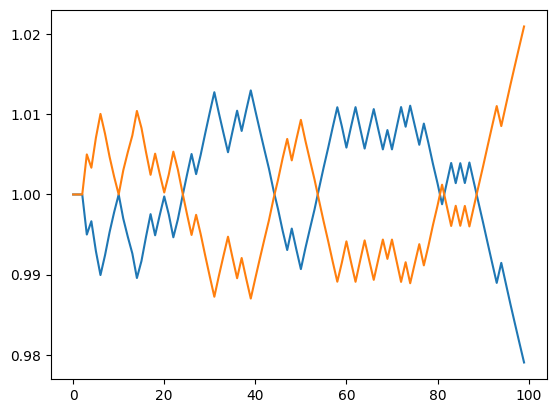

In [15]:
first_param=[x[0] for x in param_list]
sec_param=[x[1] for x in param_list]
from matplotlib import pyplot as pl
plt.plot(first_param)
plt.plot(sec_param)

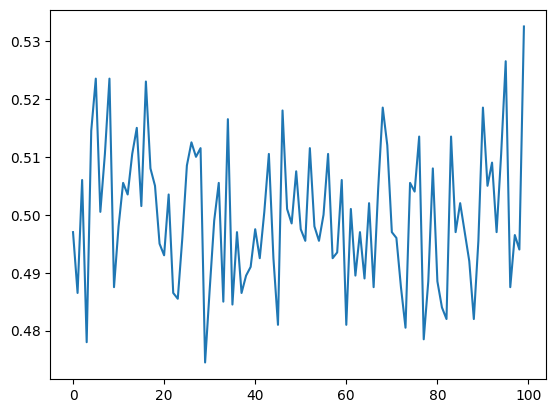

In [16]:
Q_value=Check_the_quality(Agent,env)
plt.plot(Quality_list)

In [17]:
Q_value

0.5039999999999999

# Discrete Time Dynamic system- Formulation

In [40]:
import sympy as sp
from matplotlib import pyplot as plt


## Primitive- version 1

In [45]:

n = sp.symbols('n', integer=True)  # Time step variable
theta, N1, N2 = sp.symbols('theta N1 N2', cls=sp.Function)  # State variables
gamma,R1,R2=sp.symbols('gamma R1 R2', real=True)



P_theta=sp.exp(2*theta(n))/(sp.exp(2*theta(n)) +sp.exp(2))

## Secondary

In [16]:
def Run(update_eq_list,initial_conditions,N=20,param_list=[(R2,0.2),(R1,0.8),(gamma,0.1)]):
    
    
    
    Result={
        theta:[],
        N1:[],
        N2:[]
    }
    
    for key in initial_conditions:
        Result[key].append(initial_conditions[key])
    
    for i in range(len(update_eq_list)):
        update_eq_list[i] = update_eq_list[i].subs([(R2,0.4),(R1,0.6),(gamma,0.8)])
    
    update_eq1,update_eq2,update_eq3=update_eq_list[0],update_eq_list[1],update_eq_list[2]
    
    for t in range(N):
        
        prev=initial_conditions
        prev.update({theta:float(update_eq1.subs([(theta(n), initial_conditions[theta]),(N1(n),initial_conditions[N1]),(N2(n),initial_conditions[N2])]).evalf().rhs)})
        prev.update({N1:float(update_eq2.subs([(theta(n), initial_conditions[theta]),(N1(n),initial_conditions[N1]),(N2(n),initial_conditions[N2])]).evalf().rhs)})
        prev.update({N2:float(update_eq3.subs([(theta(n), initial_conditions[theta]),(N1(n),initial_conditions[N1]),(N2(n),initial_conditions[N2])]).evalf().rhs)})
        initial_conditions=prev
        
        for key in initial_conditions:
            Result[key].append(initial_conditions[key])
        
    
    

        
        
    
    
    return Result,initial_conditions


## Plus (Both)

In [136]:
update_eq1 = sp.Eq(theta(n + 1), theta(n)+0.1*(((P_theta**2)*((R1-R2)+(1-gamma)*(sp.sqrt(1/N1(n))-sp.sqrt(1/N2(n)))))+(2 * P_theta*(R2+(1-gamma)*(sp.sqrt(1/N2(n)))))+(-1*(R2+(1-gamma)*(sp.sqrt(1/N2(n)))))))
update_eq2 = sp.Eq(N1(n + 1), N1(n)+(P_theta*gamma))
update_eq3 = sp.Eq(N2(n + 1),N2(n)+((1-P_theta)*gamma))



In [6]:

initial_conditions = {
    theta: 0.8,
    N1: 0.1,
    N2: 0.1
}

eq_list=[update_eq1,update_eq2,update_eq3]

Param_t,Latest=Run(eq_list,initial_conditions,1000)

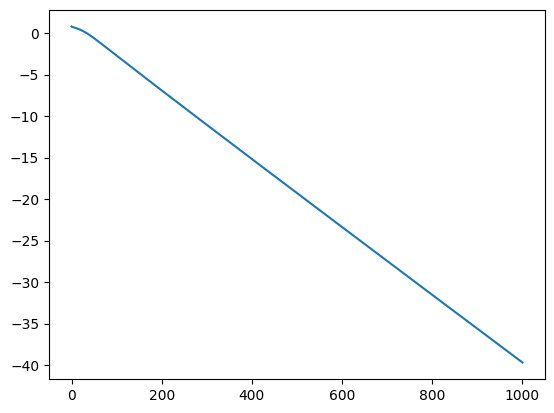

In [7]:
theta_list=Param_t[theta]
plt.plot(theta_list)

## Primitive- 2nd version

In [46]:
n = sp.symbols('n', integer=True)  # Time step variable
theta, alpha_1, beta_1,alpha_2,beta_2 = sp.symbols('theta alpha_1 beta_1 alpha_2 beta_2', cls=sp.Function)  # State variables
G,R1,R2,step=sp.symbols('G R1 R2 step', real=True)
P_theta=sp.exp(2*theta(n))/(sp.exp(2*theta(n)) +sp.exp(2))

In [58]:
def Run_five(update_eq_list,initial_conditions,param_list,N=20):
    
    # print(gamma)
    
    
    Result={
        theta:[],
        alpha_1:[],
        beta_1:[],
        alpha_2:[],
        beta_2:[]
    }
    
    for key in initial_conditions:
        Result[key].append(initial_conditions[key])
    # print(param_list)
    for i in range(len(update_eq_list)):
        update_eq_list[i] = update_eq_list[i].subs(param_list)
    
    update_eq1,update_eq2,update_eq3,update_eq4,update_eq5=update_eq_list[0],update_eq_list[1],update_eq_list[2],update_eq_list[3],update_eq_list[4]
    # print(update_eq2)
    for t in range(N):
        
        prev=initial_conditions
        prev.update({
            theta:float(update_eq1.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs)})
        
        prev.update({
            alpha_1:float(update_eq2.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs)})
        
        prev.update({
            beta_1:float(update_eq3.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs)})
        prev.update({
            alpha_2:float(update_eq4.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs)})
        prev.update({
            beta_2:float(update_eq5.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs)})
        
        # print()                        
        initial_conditions=prev
        
        for key in initial_conditions:
            Result[key].append(initial_conditions[key])
        
    
    

        
        
    
    
    return Result,initial_conditions


## Premium implementation

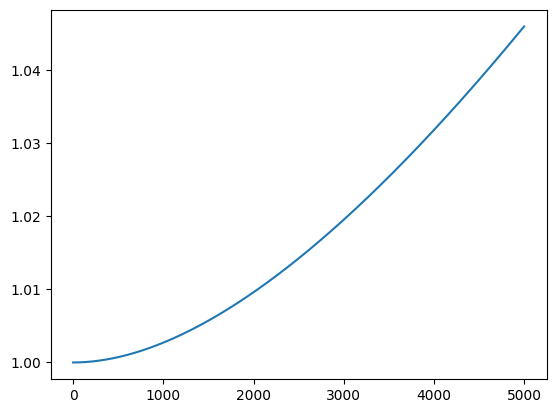

In [59]:
update_eq1 = sp.Eq(theta(n + 1), theta(n)+(step*(P_theta*(1-P_theta))*(G*R1+(1-G)*(alpha_1(n)/(alpha_1(n)+beta_1(n))))+(-1)*step*((1-P_theta)*P_theta)*(G*R2+(1-G)*(alpha_2(n)/(alpha_2(n)+beta_2(n))))))
update_eq2 = sp.Eq(alpha_1(n + 1), alpha_1(n)+(P_theta*G*R1))
update_eq3 = sp.Eq(beta_1(n + 1), beta_1(n)+(P_theta*G*(1-R1)))
update_eq4 = sp.Eq(alpha_2(n + 1), alpha_2(n)+((1-P_theta)*G*R2))
update_eq5 = sp.Eq(beta_2(n + 1), beta_2(n)+((1-P_theta)*G*(1-R2)))

initial_conditions = {
    theta: 1,
    alpha_1: 1,
    beta_1: 1,
    alpha_2: 1,
    beta_2: 1,
}

eq_list=[update_eq1,update_eq2,update_eq3,update_eq4,update_eq5]

Param_t,Latest=Run_five(eq_list,initial_conditions,[(R2,0.55),(R1,0.56),(G,0.001),(step,0.01)],5000)
theta_list=Param_t[theta]
plt.plot(theta_list)

## Exp 1 : Variation with respect to gamma 

In [ ]:




gamma_array=np.arange(0.1,1,0.1)

Gamma_theta_dict = {}  # Dictionary to store results

for value in gamma_array:
    
    update_eq1 = sp.Eq(theta(n + 1), theta(n)+(step*(P_theta*(1-P_theta))*(G*R1+(1-G)*(alpha_1(n)/(alpha_1(n)+beta_1(n))))+(-1)*step*((1-P_theta)*P_theta)*(G*R2+(1-G)*(alpha_2(n)/(alpha_2(n)+beta_2(n))))))
    update_eq2 = sp.Eq(alpha_1(n + 1), alpha_1(n)+(P_theta*G*R1))
    update_eq3 = sp.Eq(beta_1(n + 1), beta_1(n)+(P_theta*G*(1-R1)))
    update_eq4 = sp.Eq(alpha_2(n + 1), alpha_2(n)+((1-P_theta)*G*R2))
    update_eq5 = sp.Eq(beta_2(n + 1), beta_2(n)+((1-P_theta)*G*(1-R2)))
    
    eq_list=[update_eq1,update_eq2,update_eq3,update_eq4,update_eq5]

    # print(float(value))
    
    
    
    
    initial_conditions = {
    theta: 1,
    alpha_1: 1,
    beta_1: 1,
    alpha_2: 1,
    beta_2: 1,
    }
    
    Param_t,Latest=Run_five(eq_list,initial_conditions,[(R2,0.2),(R1,0.8),(G,float(value)),(step,0.1)],1000)
    theta_list=Param_t[theta]
    Gamma_theta_dict[value] = theta_list  # Store the result in the dictionary


for gamma in Gamma_theta_dict.keys():
    plt.plot(Gamma_theta_dict[gamma],label=str(gamma))
plt.title("Learning curve")
plt.legend()
plt.show()


In [212]:
gamma_array

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [47]:
S1,S2=sp.symbols('S1 S2', real=True)

In [48]:
def Run_three(update_eq_list,initial_conditions,param_list,N=20):
    
    
    
    Result={
        theta:[],
        N1:[],
        N2:[]
    }
    
    for key in initial_conditions:
        Result[key].append(initial_conditions[key])
    
    for i in range(len(update_eq_list)):
        update_eq_list[i] = update_eq_list[i].subs(param_list)
        # print(update_eq_list[i])
    
    update_eq1,update_eq2,update_eq3=update_eq_list[0],update_eq_list[1],update_eq_list[2]
    
    for t in range(N):
        
        prev=initial_conditions
        # print(update_eq2.subs([(theta(n), initial_conditions[theta]),(N1(n),initial_conditions[N1]),(N2(n),initial_conditions[N2])]).evalf().rhs)
        prev.update({theta:float(update_eq1.subs([(theta(n), initial_conditions[theta]),(N1(n),initial_conditions[N1]),(N2(n),initial_conditions[N2])]).evalf().rhs)})
        prev.update({N1:float(update_eq2.subs([(theta(n), initial_conditions[theta]),(N1(n),initial_conditions[N1]),(N2(n),initial_conditions[N2])]).evalf().rhs)})
        prev.update({N2:float(update_eq3.subs([(theta(n), initial_conditions[theta]),(N1(n),initial_conditions[N1]),(N2(n),initial_conditions[N2])]).evalf().rhs)})
        initial_conditions=prev
        
        for key in initial_conditions:
            Result[key].append(initial_conditions[key])
        
    
    

        
        
    
    
    return Result,initial_conditions


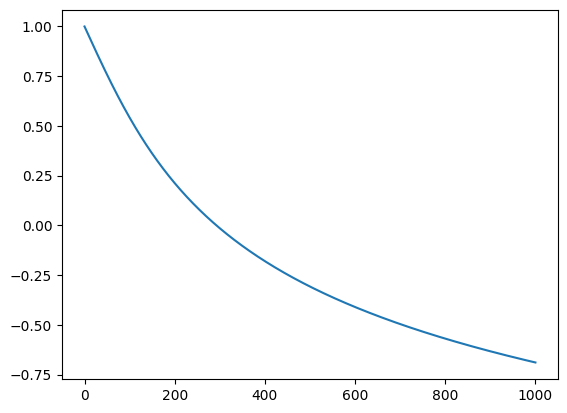

In [54]:
update_eq1 = sp.Eq(theta(n + 1), theta(n)+step*P_theta*(1-P_theta)*((R1-R2)+(1-G)*(S1*sp.sqrt(1/N1(n))-S2*sp.sqrt(1/N2(n)))))
update_eq2 = sp.Eq(N1(n + 1), N1(n)+(P_theta*G))
update_eq3 = sp.Eq(N2(n + 1),N2(n)+((1-P_theta)*G))


initial_conditions = {
    theta: 1,
    N1: 1,
    N2: 1
}

eq_list=[update_eq1,update_eq2,update_eq3]

Param_t,Latest=Run_three(eq_list,initial_conditions,[(R2,0.55),(R1,0.56),(G,0.001),(step,0.01),(S1,-1),(S2,1)],1000)
theta_list=Param_t[theta]
plt.plot(theta_list)


## Exp 1 : Variation with respect to gamma - 3 D

## Under:
 
### N1 = 0.01
### N2 = 0.01
### init_theta = 1
### R2 = 0.5
### R1 = 0.6
### step_size = 0.1
### S1 = -1
### S2 =  1
### num_of_epochs = 3000

100%|██████████| 9/9 [58:14<00:00, 388.32s/it]


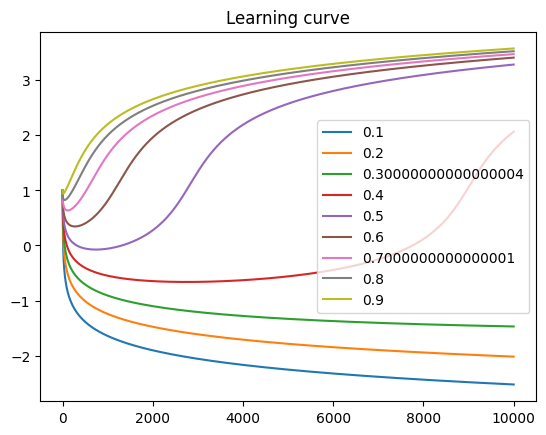

In [36]:




gamma_array=np.arange(0.1,1,0.1)

Gamma_theta_dict_3 = {}  # Dictionary to store results

for value in tqdm(gamma_array):
    
    update_eq1 = sp.Eq(theta(n + 1), theta(n)+step*P_theta*(1-P_theta)*((R1-R2)+(1-G)*(S1*sp.sqrt(1/N1(n))-S2*sp.sqrt(1/N2(n)))))
    update_eq2 = sp.Eq(N1(n + 1), N1(n)+(P_theta*G))
    update_eq3 = sp.Eq(N2(n + 1),N2(n)+((1-P_theta)*G))
        
    eq_list=[update_eq1,update_eq2,update_eq3]

    # print(float(value))
    
    initial_conditions = {
    theta: 1,
    N1: 1,
    N2: 1
    }
    
    

    Param_t,Latest=Run_three(eq_list,initial_conditions,[(R2,0.5),(R1,0.6),(G,float(value)),(step,0.01),(S1,-1),(S2,1)],10000)
    theta_list=Param_t[theta]
    
    
    
    Gamma_theta_dict_3[value] = theta_list  # Store the result in the dictionary


for gamma in Gamma_theta_dict_3.keys():
    plt.plot(Gamma_theta_dict_3[gamma],label=str(gamma))
plt.title("Learning curve")
plt.legend()
plt.show()


## Exp 1 : Variation with respect to gamma - 3 D - with a "less hard env "

## Under:
 
### N1 = 0.01
### N2 = 0.01
### init_theta = 1
### R2 = 0.2
### R1 = 0.8
### step_size = 0.1
### S1 = -1
### S2 =  1
### num_of_epochs = 3000

100%|██████████| 9/9 [17:47<00:00, 118.62s/it]


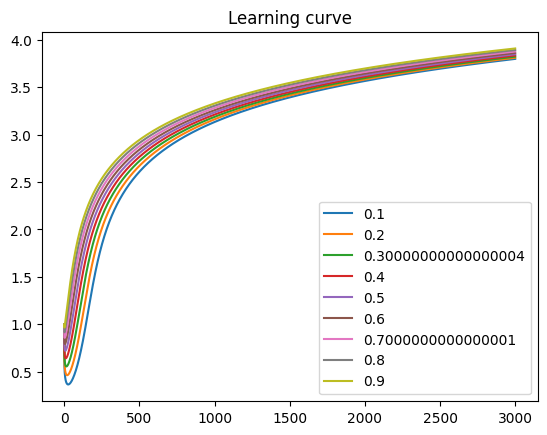

In [273]:




gamma_array=np.arange(0.1,1,0.1)

Gamma_theta_dict_3 = {}  # Dictionary to store results

for value in tqdm(gamma_array):
    
    update_eq1 = sp.Eq(theta(n + 1), theta(n)+step*P_theta*(1-P_theta)*((R1-R2)+(1-G)*(S1*sp.sqrt(1/N1(n))-S2*sp.sqrt(1/N2(n)))))
    update_eq2 = sp.Eq(N1(n + 1), N1(n)+(P_theta*gamma))
    update_eq3 = sp.Eq(N2(n + 1),N2(n)+((1-P_theta)*gamma))
        
    eq_list=[update_eq1,update_eq2,update_eq3]

    # print(float(value))
    
    initial_conditions = {
    theta: 1,
    N1: 0.01,
    N2: 0.01
    }
    
    

    Param_t,Latest=Run_three(eq_list,initial_conditions,[(R2,0.2),(R1,0.8),(G,float(value)),(step,0.1),(S1,-1),(S2,1)],3000)
    theta_list=Param_t[theta]
    
    
    
    Gamma_theta_dict_3[value] = theta_list  # Store the result in the dictionary


for gamma in Gamma_theta_dict_3.keys():
    plt.plot(Gamma_theta_dict_3[gamma],label=str(gamma))
plt.title("Learning curve")
plt.legend()
plt.show()


## Exp 1 : Variation with respect to gamma - 3 D - with a "hard env "

## Under:
 
### N1 = 1
### N2 = 1
### init_theta = 1
### R2 = 0.5
### R1 = 0.6
### step_size = 0.1
### S1 = -1
### S2 =  1
### num_of_epochs = 3000

100%|██████████| 9/9 [19:40<00:00, 131.20s/it]


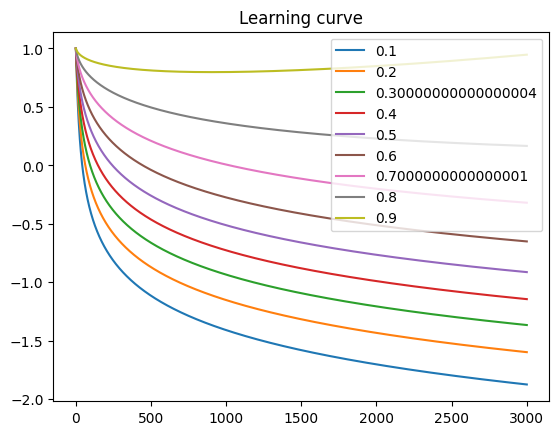

In [40]:




gamma_array=np.arange(0.1,1,0.1)

Gamma_theta_dict_3 = {}  # Dictionary to store results

for value in tqdm(gamma_array):
    
    update_eq1 = sp.Eq(theta(n + 1), theta(n)+step*P_theta*(1-P_theta)*((R1-R2)+(1-G)*(S1*sp.sqrt(1/N1(n))-S2*sp.sqrt(1/N2(n)))))
    update_eq2 = sp.Eq(N1(n + 1), N1(n)+(P_theta*G))
    update_eq3 = sp.Eq(N2(n + 1),N2(n)+((1-P_theta)*G))
        
    eq_list=[update_eq1,update_eq2,update_eq3]

    # print(float(value))
    
    initial_conditions = {
    theta: 1,
    N1: 1,
    N2: 1
    }
    
    

    Param_t,Latest=Run_three(eq_list,initial_conditions,[(R2,0.55),(R1,0.56),(G,float(value)),(step,0.1),(S1,-1),(S2,1)],3000)
    theta_list=Param_t[theta]
    
    
    
    Gamma_theta_dict_3[value] = theta_list  # Store the result in the dictionary


for gamma in Gamma_theta_dict_3.keys():
    plt.plot(Gamma_theta_dict_3[gamma],label=str(gamma))
plt.title("Learning curve")
plt.legend()
plt.show()
